## **CNN para classificação (binária) multiclasse de imagens**
**Dataset Fashion-MNIST**
- Dataset de imagens de peças de vestuário
- Imagens de 28x28 pixeis
- 70k imagens das quais 60k são para treino e 10k para teste
- 10 classes e 785 atributos (o 1º é a classe a classificar o tipo de vestuário e as restantes são valores dos pixéis das imagens)
- Classes: T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag e Ankle boot
    
Vamos utilizar uma rede neuronal para classificação do dígito em cada imagem de 28x28.

## imports

In [51]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch import Tensor
import torch.nn as nn
from torch.nn import BatchNorm2d
from torch.nn import Dropout2d
from torch.nn import Sequential
from torch.nn import Linear
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import Softmax
from torch.nn import Module
from torch.nn import CrossEntropyLoss
from torch.optim import SGD, Adam
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_
 
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
from torchvision.transforms import Normalize
from torchinfo import summary

from livelossplot import PlotLosses

np.random.seed(0) 
torch.manual_seed(0)
import random
random.seed(0)

In [52]:
PATH = './'
PATH_TRAIN = './fashion-mnist_train.csv'
PATH_TEST = './fashion-mnist_test.csv'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BATCH_SIZE = 32

In [53]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_default_device () :
    if torch.cuda.is_available( ):
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device (data, device):
    if isinstance (data, (list, tuple)) :
        return [to_device (x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader ():

    def init_(self, dl, device):
        self.dl = dl
        self.device = device

    def iter_(self):
        for b in self.d1:
            yield to_device (b, self.device)

    def len_(self):
        return len(self.dl)

device = get_default_device()
print(device)

cpu


## 1. Preparar os Dados

In [54]:
train_transform = Compose(
        [ToTensor(), 
         Normalize(mean=(0.1307,), std=(0.3081,)) 
        ])
test_transform = Compose(
        [ToTensor(), 
         Normalize(mean=(0.1307,), std=(0.3081,))
        ])

In [55]:
class CSVDataset(Dataset):
    def __init__(self, path, transform=None):
        self.transform = transform
        df_set = pd.read_csv(path, header=0)
        self.x = df_set.values[:, 1:]
        self.y = df_set.values[:, 0]
        self.x = self.x.astype('float32')
        self.y = self.y.astype('long')

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        label = self.y[idx]
        image = self.x[idx]
        if self.transform is not None:
            image = self.transform(image)
        return image, label
    
    def get_TensorDataset(self):
        x = self.x.reshape(len(self.x), 1, 28, 28)
        xmax, xmin = x.max(), x.min()
        x = (x - xmin)/ (xmax - xmin)
        x = torch.from_numpy(np.array(x)).float()
        y = torch.from_numpy(np.array(self.y)).type(torch.LongTensor)
        cases = torch.utils.data.TensorDataset(x, y)
        return cases

def prepare_data_loaders(path_train, path_test):
    dataset_train = CSVDataset(path=path_train, transform=train_transform)
    dataset_test = CSVDataset(path=path_test, transform=test_transform)
    train = dataset_train.get_TensorDataset()
    train_size = int(0.8 * len(train))
    val_size = len(train) - train_size
    train, validation = random_split(train, [train_size, val_size], generator=torch.Generator().manual_seed(42))
    test = dataset_test.get_TensorDataset()
    train_dl = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
    val_dl = DataLoader(validation, batch_size=BATCH_SIZE, shuffle=True)
    test_dl = DataLoader(test, batch_size=BATCH_SIZE, shuffle=True)
    train_dl_all = DataLoader(train, batch_size=len(train), shuffle=False)
    val_dl_all = DataLoader(validation, batch_size=len(validation), shuffle=True)
    test_dl_all = DataLoader(test, batch_size=len(test), shuffle=False)
    return train_dl, val_dl, test_dl, train_dl_all, val_dl_all, test_dl_all

train_dl, val_dl, test_dl, train_dl_all, val_dl_all, test_dl_all = prepare_data_loaders(PATH_TRAIN, PATH_TEST)


## 1.1 Visualizar os Dados

In [56]:
def output_label(label):
    output_mapping = { 0: "T-shirt/Top", 1: "Trouser", 2: "Pullover",
                       3: "Dress",       4: "Coat",    5: "Sandal", 
                       6: "Shirt",       7: "Sneaker", 8: "Bag", 
                       9: "Ankle Boot" }
    output_mapping2 = { 0: "0", 1: "1", 2: "2", 3: "3", 4: "4", 
                       5: "5", 6: "6", 7: "7", 8: "8", 9: "9"}
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

In [57]:
from IPython.display import display

def visualize_data(path):
    df = pd.read_csv(path, header=0)
    display(df)

def visualize_dataset(train_dl, val_dl, test_dl):
    print(f"Quantidade de casos de Treino:{ len(train_dl.dataset) }")
    print(f"Quantidade de casos de Validação:{ len(val_dl.dataset) }")
    print(f"Quantidade de casos de Teste:{ len(test_dl.dataset) }")
    x, y = next(iter(train_dl))
    print(f"Shape tensor batch casos treino, input: {x.shape}, output: {y.shape}")
    x, y = next(iter(val_dl))
    print(f"Shape tensor batch casos validação, input: {x.shape}, output:{y.shape}")
    x, y = next(iter(test_dl))
    print(f"Shape tensor batch casos test, input: {x.shape}, output: {y.shape}")
    print(f'Valor máximo:{torch.max(x)} Valor minimo:{torch.min(x)}')
    x = x.detach().numpy()
    print(f'Valor máximo: {np.max(x)} Valor mínimo:{np.min(x)}')
    print(y)


visualize_data(PATH_TRAIN)
visualize_dataset(train_dl, val_dl, test_dl)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,1,0,0,0,0,0,0,0,0,0,...,73,0,0,0,0,0,0,0,0,0
59997,8,0,0,0,0,0,0,0,0,0,...,160,162,163,135,94,0,0,0,0,0
59998,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Quantidade de casos de Treino:48000
Quantidade de casos de Validação:12000
Quantidade de casos de Teste:10000
Shape tensor batch casos treino, input: torch.Size([32, 1, 28, 28]), output: torch.Size([32])
Shape tensor batch casos validação, input: torch.Size([32, 1, 28, 28]), output:torch.Size([32])
Shape tensor batch casos test, input: torch.Size([32, 1, 28, 28]), output: torch.Size([32])
Valor máximo:1.0 Valor minimo:0.0
Valor máximo: 1.0 Valor mínimo:0.0
tensor([8, 8, 4, 0, 9, 7, 5, 2, 5, 4, 9, 8, 8, 8, 5, 3, 3, 2, 5, 3, 4, 0, 3, 2,
        3, 0, 0, 0, 2, 0, 9, 9])


torch.Size([32, 1, 28, 28])


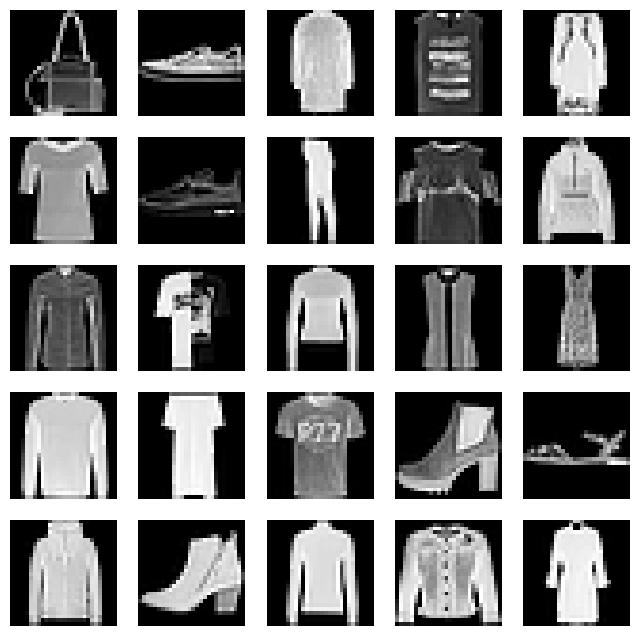

In [58]:
def visualize_images(dl):
    i, (inputs, targets) = next(enumerate(dl))
    print(inputs.shape)
    plt.figure(figsize=(8,8))
    for i in range(25):
        plt.subplot (5, 5, i+1)
        plt.axis('off')
        plt.grid()
        plt.imshow(inputs [i][0], cmap='gray')
    plt.show()

visualize_images(train_dl)

## 1.2 Verificar balanceamento do dataset

## 2. Definir o Modelo

In [59]:
class CNNModel_1(Module):
    def __init__(self):
        super(CNNModel_1, self).__init__()
        self.layer1 = Sequential(Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3)), 
                                 ReLU(), 
                                 MaxPool2d(kernel_size=(2,2), stride=(2,2)))
        self.layer2 = Sequential(Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3)), 
                                 ReLU(), 
                                 MaxPool2d(kernel_size=(2,2), stride=(2,2)))
        self.fc1 = Linear(in_features=5*5*32, out_features=100)
        kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
        self.act1 = ReLU()
        self.fc2 = Linear(in_features=100, out_features=10)
        xavier_uniform_(self.fc2.weight)
        self.act2 = Softmax(dim=1)
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(-1, 4*4*50)
        out = self.fc1(out)
        out = self.act1(out)
        out = self.fc2(out)
        out = self.act2(out)
        return out

model = CNNModel_1()
print(summary(model, input_size=(BATCH_SIZE, 1,28,28), verbose=0))
model.to(device)

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel_1                               [32, 10]                  --
├─Sequential: 1-1                        [32, 32, 13, 13]          --
│    └─Conv2d: 2-1                       [32, 32, 26, 26]          320
│    └─ReLU: 2-2                         [32, 32, 26, 26]          --
│    └─MaxPool2d: 2-3                    [32, 32, 13, 13]          --
├─Sequential: 1-2                        [32, 32, 5, 5]            --
│    └─Conv2d: 2-4                       [32, 32, 11, 11]          9,248
│    └─ReLU: 2-5                         [32, 32, 11, 11]          --
│    └─MaxPool2d: 2-6                    [32, 32, 5, 5]            --
├─Linear: 1-3                            [32, 100]                 80,100
├─ReLU: 1-4                              [32, 100]                 --
├─Linear: 1-5                            [32, 10]                  1,010
├─Softmax: 1-6                           [32, 10]                  --
Tota

CNNModel_1(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=800, out_features=100, bias=True)
  (act1): ReLU()
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (act2): Softmax(dim=1)
)

In [60]:
class CNNModel_2(Module):
    def __init__(self):
        super(CNNModel_2, self).__init__()
        self.layer1 = Sequential(Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=0),
        ReLU(),
        MaxPool2d(kernel_size=2)
        )
        self.layer2 = Sequential(Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0),
        ReLU(),
        MaxPool2d(kernel_size=2)
        )
        self.fc1 = Linear(32 * 5 * 5, 10) 
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        return out


model = CNNModel_2()
print(summary(model, input_size=(BATCH_SIZE, 1,28,28), verbose=0))

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel_2                               [32, 10]                  --
├─Sequential: 1-1                        [32, 16, 13, 13]          --
│    └─Conv2d: 2-1                       [32, 16, 26, 26]          160
│    └─ReLU: 2-2                         [32, 16, 26, 26]          --
│    └─MaxPool2d: 2-3                    [32, 16, 13, 13]          --
├─Sequential: 1-2                        [32, 32, 5, 5]            --
│    └─Conv2d: 2-4                       [32, 32, 11, 11]          4,640
│    └─ReLU: 2-5                         [32, 32, 11, 11]          --
│    └─MaxPool2d: 2-6                    [32, 32, 5, 5]            --
├─Linear: 1-3                            [32, 10]                  8,010
Total params: 12,810
Trainable params: 12,810
Non-trainable params: 0
Total mult-adds (M): 21.68
Input size (MB): 0.10
Forward/backward pass size (MB): 3.76
Params size (MB): 0.05
Estimated Total Size (MB): 3.91


In [61]:
class CNNModel_3(Module):
    def __init__(self):
        super(CNNModel_3, self).__init__()
        self.layer1 = nn.Sequential(Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
                                    BatchNorm2d(32),
                                    ReLU(),
                                    MaxPool2d(kernel_size=2, stride=2)
                                    )
        self.layer2 = nn.Sequential(Conv2d(in_channels=32, out_channels=64, kernel_size=3),
                                    BatchNorm2d(64),
                                    ReLU(),
                                    MaxPool2d(2)
                                    )
        self.fc1 = Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = Linear(in_features=600, out_features=120)
        self.fc3 = Linear(in_features=120, out_features=10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

    
model = CNNModel_3()
print(summary(model, input_size=(BATCH_SIZE, 1,28,28), verbose=0))

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel_3                               [32, 10]                  --
├─Sequential: 1-1                        [32, 32, 14, 14]          --
│    └─Conv2d: 2-1                       [32, 32, 28, 28]          320
│    └─BatchNorm2d: 2-2                  [32, 32, 28, 28]          64
│    └─ReLU: 2-3                         [32, 32, 28, 28]          --
│    └─MaxPool2d: 2-4                    [32, 32, 14, 14]          --
├─Sequential: 1-2                        [32, 64, 6, 6]            --
│    └─Conv2d: 2-5                       [32, 64, 12, 12]          18,496
│    └─BatchNorm2d: 2-6                  [32, 64, 12, 12]          128
│    └─ReLU: 2-7                         [32, 64, 12, 12]          --
│    └─MaxPool2d: 2-8                    [32, 64, 6, 6]            --
├─Linear: 1-3                            [32, 600]                 1,383,000
├─Dropout2d: 1-4                         [32, 600]                 --
├─

/home/purp/anaconda3/envs/deepl/lib/python3.9/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


In [62]:
class CNNModel_4(Module):
    def __init__(self):
        super(CNNModel_4, self).__init__()
        self.layer1 = Sequential(nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=0),
                                BatchNorm2d(32),
                                ReLU(),
                                MaxPool2d(2),
                                Dropout2d(0.2)
                                )
        self.fc1 = Linear(in_features=32*12*12, out_features=128)
        self.fc2 = Linear(in_features=128, out_features=10)
    
    def forward(self, x):
        out = self.layer1(x)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

model = CNNModel_4()
print(summary(model, input_size=(BATCH_SIZE, 1,28,28), verbose=0))

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel_4                               [32, 10]                  --
├─Sequential: 1-1                        [32, 32, 12, 12]          --
│    └─Conv2d: 2-1                       [32, 32, 24, 24]          832
│    └─BatchNorm2d: 2-2                  [32, 32, 24, 24]          64
│    └─ReLU: 2-3                         [32, 32, 24, 24]          --
│    └─MaxPool2d: 2-4                    [32, 32, 12, 12]          --
│    └─Dropout2d: 2-5                    [32, 32, 12, 12]          --
├─Linear: 1-2                            [32, 128]                 589,952
├─Linear: 1-3                            [32, 10]                  1,290
Total params: 592,138
Trainable params: 592,138
Non-trainable params: 0
Total mult-adds (M): 34.26
Input size (MB): 0.10
Forward/backward pass size (MB): 9.47
Params size (MB): 2.37
Estimated Total Size (MB): 11.94


## 3. Treinar o Modelo

In [63]:
def train_model(h5_file, train_dl, val_dl, model, criterion, optimizer):
    liveloss = PlotLosses()
    
    for epoch in range(EPOCHS):
        logs = {}
        model.train()
        running_loss = 0.0
        running_corrects = 0.0
        for inputs, labels in train_dl:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.detach() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / len(train_dl.dataset)
            epoch_acc = running_corrects.float()/len(train_dl.dataset)
            logs['loss'] = epoch_loss.item()
            logs['accuracy'] = epoch_acc.item()
            model.eval()
    
            running_loss = 0.0
            running_corrects = 0.0
            for inputs, labels in val_dl:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.detach() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                running_corrects += torch.sum(preds == labels.data)
                epoch_loss = running_loss / len(val_dl.dataset)
                epoch_acc = running_corrects.float() / len(val_dl.dataset)
                logs['val_loss'] = epoch_loss.item()
                logs['val_accuracy'] = epoch_acc.item()
                liveloss.update(logs)
                liveloss.send()
    torch.save(model,h5_file)

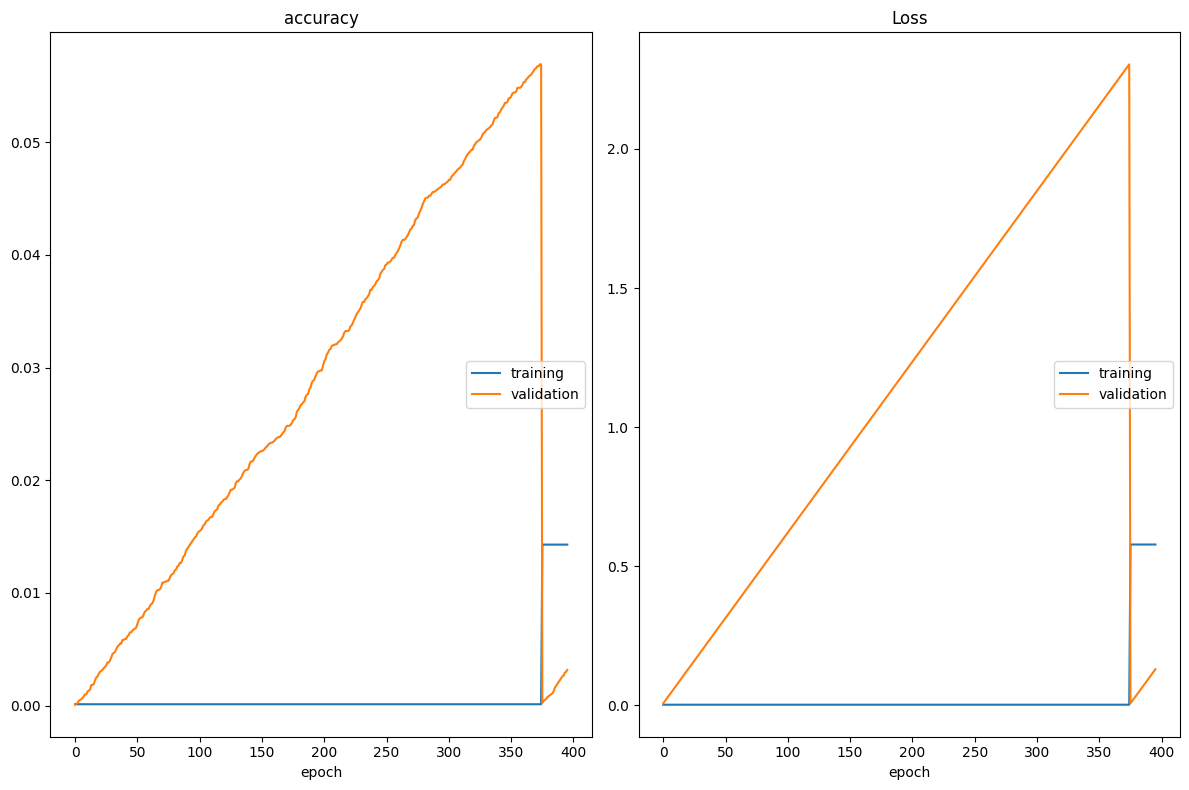

accuracy
	training         	 (min:    0.000, max:    0.014, cur:    0.014)
	validation       	 (min:    0.000, max:    0.057, cur:    0.003)
Loss
	training         	 (min:    0.002, max:    0.578, cur:    0.578)
	validation       	 (min:    0.006, max:    2.304, cur:    0.129)


KeyboardInterrupt: 

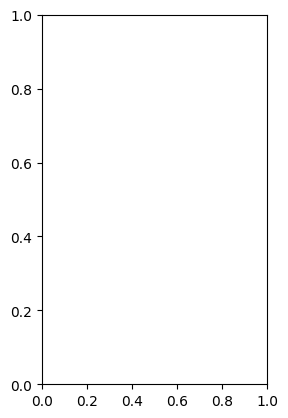

In [64]:
######### CNNModel_1 ################
model = CNNModel_1()
print(summary(model, input_size=(BATCH_SIZE, 1,28, 28), verbose=0))
model.to(device)

EPOCHS = 15
LEARNING_RATE = .001
criterion = CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=LEARNING_RATE)
starttime = time.perf_counter()
train_model('CNNModel_1.pth', train_dl, val_dl, model, criterion, optimizer)
endtime = time.perf_counter()
print(f"Tempo gasto: {endtime - starttime} segundos")

In [ ]:
######### CNNModel_2 ################
model = CNNModel_2()
print(summary(model, input_size=(BATCH_SIZE, 1,28,28), verbose=0))

In [ ]:
######### CNNModel_3 ################
model = CNNModel_3()
print(summary(model, input_size=(BATCH_SIZE, 1,28,28), verbose=0))

In [ ]:
######### CNNModel_4 ################
model = CNNModel_4()
print(summary(model, input_size=(BATCH_SIZE, 1,28,28), verbose=0))

## 4. Avaliar o Modelo

In [ ]:
def evaluate_model(test_dl, model):
    predictions = list()
    actual_values = list()
    for inputs, labels in test_dl:
        inputs = inputs.to(device)
        labels = labels.to(device)
        yprev = model(inputs)
        yprev = yprev.detach().cpu().numpy()
        actual = labels.cpu().numpy()
        yprev = np.argmax(yprev, axis=1)
        actual = actual.reshape((len(actual), 1))
        yprev = yprev.reshape((len(yprev), 1))
        predictions.append(yprev)
        actual_values.append(actual)
        break
    predictions, actual_values = np.vstack(predictions), np.vstack(actual_values)
    return actual_values, predictions

def display_predictions(actual_values, predictions ):
    acertou=0
    falhou = 0
    primeiros=0
    for r,p in zip(actual_values, predictions):
        if primeiros <20:
            print(f'real:{r} previsão:{p}')
            primeiros +=1
        if r==p: acertou+=1
        else: falhou+=1
    corrects = np.sum(predictions == actual_values)
    acc = corrects/len(test_dl.dataset)
    acc = accuracy_score(actual_values, predictions)
    print(f'Accuracy: {acc:0.3f}\n')
    print(f'acertou:{acertou} falhou:{falhou}')
    acc = accuracy_score(actual_values, predictions)
    print(f'Accuracy: {acc:0.3f}\n')
    print(f'acertou:{acertou} falhou:{falhou}')
    
def display_confusion_matrix(cm,list_classes):
    plt.figure(figsize = (16,8))
    sns.heatmap(cm,annot=True,xticklabels=list_classes,yticklabels=list_classes, annot_kws={"size": 12}, fmt='g', linewidths=.5)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show() 
        
actual_values, predictions = evaluate_model(test_dl_all, model)
display_predictions(actual_values, predictions )
print(classification_report(actual_values, predictions))
cr =classification_report(actual_values, predictions, output_dict=True)
list_classes=[output_label(n) for n in list(cr.keys())[0:10] ] 
cm = confusion_matrix(actual_values, predictions)

print (cm)
display_confusion_matrix(cm,list_classes)

## 5. Usar o Modelo

In [ ]:
def make_prediction(model, img):
    img = img.reshape(1, 1, 28, 28)
    print(img.shape)
    print(img.dtype)
    img = img.to(device) #valves
    prediction = model(img).cpu().detach().numpy()[0].argmax()
    print("predict:",prediction)
    img=img.cpu()
    plt.axis('off')
    plt.grid(b=None)
    plt.imshow(img[0,0], cmap=plt.get_cmap('gray'))
    plt.show()

model= torch.load('CNNModel_1.pth')
imagens, label = next(iter(test_dl))
make_prediction(model,imagens[3])